In [4]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from mlxtend.frequent_patterns import fpgrowth, association_rules
from scipy.sparse import csr_matrix

In [5]:
# --- Étape 1 : Chargement et nettoyage des données ---
print("Chargement des données...")
df = pd.read_excel("Online Retail.xlsx")

# Suppression des lignes sans CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Suppression des lignes avec quantités ou prix négatifs
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Création de la colonne 'TotalPrice'
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

Chargement des données...


Analyse exploratoire en cours...
            Quantity                    InvoiceDate      UnitPrice  \
count  397884.000000                         397884  397884.000000   
mean       12.988238  2011-07-10 23:41:23.511023360       3.116488   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-07 11:12:00       1.250000   
50%         6.000000            2011-07-31 14:39:00       1.950000   
75%        12.000000            2011-10-20 14:33:00       3.750000   
max     80995.000000            2011-12-09 12:50:00    8142.750000   
std       179.331775                            NaN      22.097877   

          CustomerID     TotalPrice  
count  397884.000000  397884.000000  
mean    15294.423453      22.397000  
min     12346.000000       0.001000  
25%     13969.000000       4.680000  
50%     15159.000000      11.800000  
75%     16795.000000      19.800000  
max     18287.000000  168469.600000  
std      1713.141560     309.071

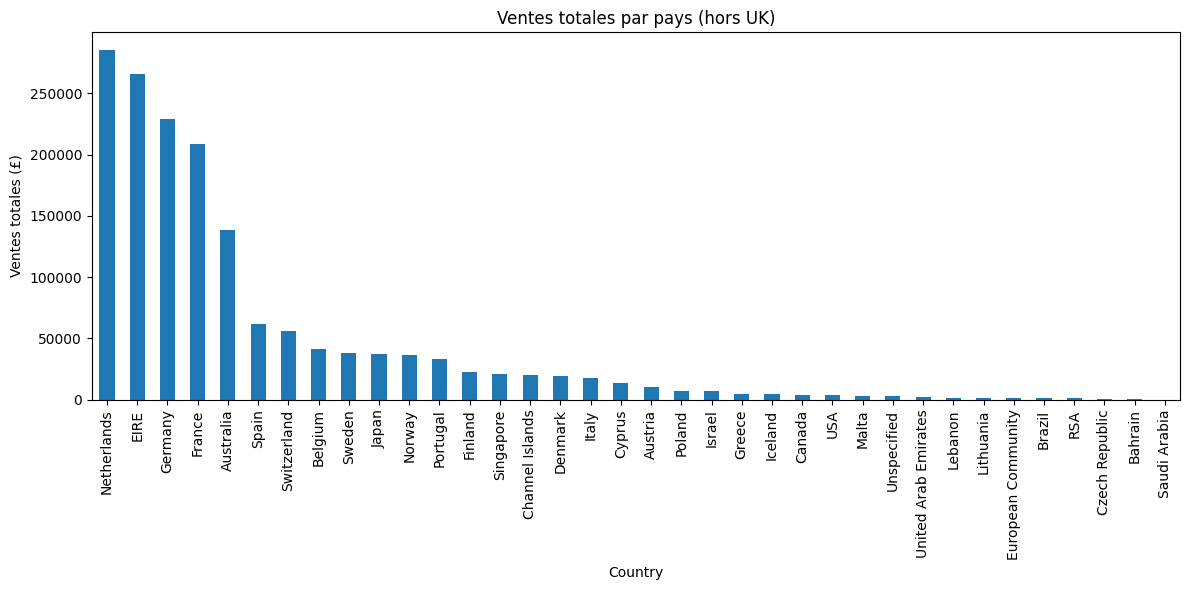

In [6]:
# --- Étape 2 : Analyse exploratoire ---
print("Analyse exploratoire en cours...")
print(df.describe())
print("Pays avec le plus de transactions :\n", df['Country'].value_counts().head())

# Ventes par pays (hors Royaume-Uni)
df_non_uk = df[df['Country'] != 'United Kingdom']
ventes_pays = df_non_uk.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

# Visualisation
plt.figure(figsize=(12,6))
ventes_pays.plot(kind='bar', title='Ventes totales par pays (hors UK)')
plt.ylabel('Ventes totales (£)')
plt.tight_layout()
plt.show()

In [7]:
# --- Étape 3 : Analyse RFM ---
print("Calcul des variables RFM...")
date_reference = df['InvoiceDate'].max() + timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (date_reference - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Récence',
    'InvoiceNo': 'Fréquence',
    'TotalPrice': 'Montant'
}).reset_index()

# Normalisation des variables RFM
scaler = StandardScaler()
rfm_norm = scaler.fit_transform(rfm[['Récence', 'Fréquence', 'Montant']])

Calcul des variables RFM...


Application du clustering K-means...


c:\Users\rania\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rania\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rania\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rania\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\

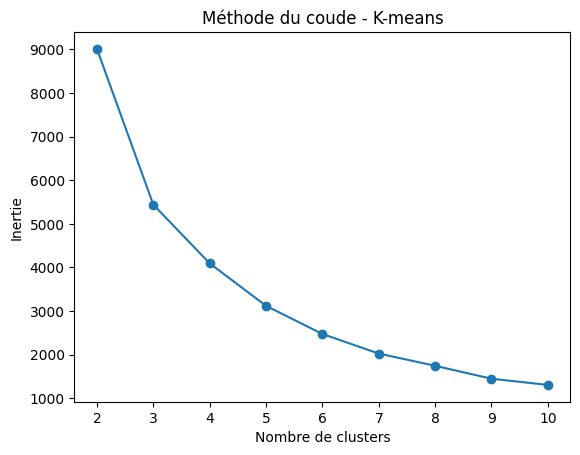

c:\Users\rania\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [8]:
# --- Étape 4 : Clustering K-means ---
print("Application du clustering K-means...")
inerties = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(rfm_norm)
    inerties.append(kmeans.inertia_)

# Méthode du coude
plt.figure()
plt.plot(range(2, 11), inerties, marker='o')
plt.title('Méthode du coude - K-means')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

# Application de K-means avec k=4
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster_KMeans'] = kmeans.fit_predict(rfm_norm)

Application du clustering hiérarchique...


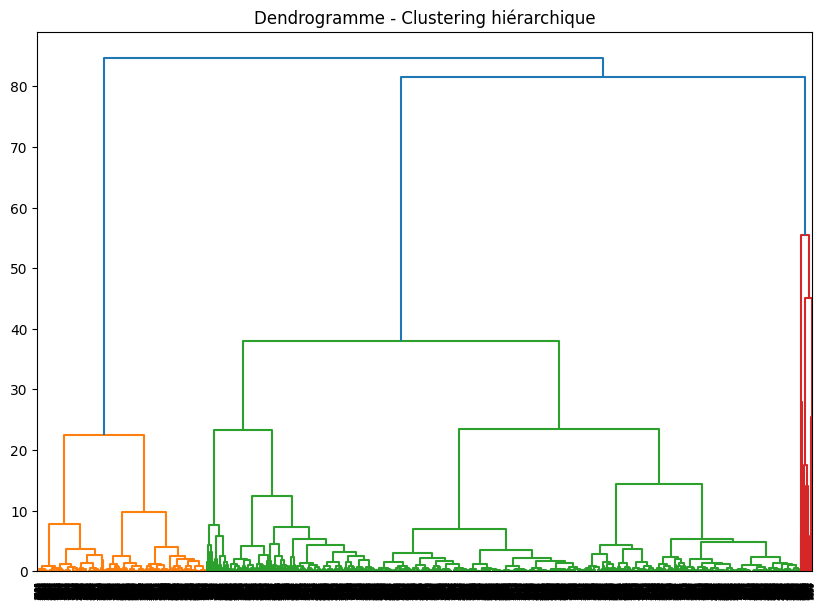

In [9]:
# --- Étape 5 : Clustering hiérarchique (CAH) ---
print("Application du clustering hiérarchique...")
liaison = linkage(rfm_norm, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(liaison)
plt.title("Dendrogramme - Clustering hiérarchique")
plt.show()

# Attribution des clusters (ex. 4)
rfm['Cluster_CAH'] = fcluster(liaison, t=4, criterion='maxclust')

In [10]:
# --- Étape 6 : Règles d'association ---
print("Extraction des règles d'association...")

# Limiter le jeu de données à 2000 transactions pour éviter la surcharge mémoire
subset_df = df[df['Quantity'] > 1].head(2000)

# Sélectionner les 50 produits les plus fréquents pour réduire la dimension
top_products = df['Description'].value_counts().head(50).index
subset_df = subset_df[subset_df['Description'].isin(top_products)]

# Création du panier binaire
basket = subset_df.pivot_table(
    index='InvoiceNo',
    columns='Description',
    values='Quantity',
    aggfunc='sum'
).fillna(0)

# Conversion explicite en booléen (True/False)
basket = basket.astype(bool)

# Utilisation de FP-growth avec une matrice sparse
itemsets_frequents = fpgrowth(basket, min_support=0.01, use_colnames=True)

# Extraction des règles
regles = association_rules(itemsets_frequents, metric="lift", min_threshold=1.0)

# Affichage des principales règles
regles = regles.sort_values(by='lift', ascending=False)
print("Top 10 des règles d’association :")
print(regles[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# --- Enregistrement des résultats ---
rfm.to_csv("Segments_RFM.csv", index=False)
regles.to_csv("Regles_Association.csv", index=False)

print("✅ Analyse terminée avec succès.")

Extraction des règles d'association...
Top 10 des règles d’association :
                                            antecedents  \
628   (LUNCH BAG  BLACK SKULL., JUMBO STORAGE BAG SUKI)   
2432  (LUNCH BAG SPACEBOY DESIGN , WHITE HANGING HEA...   
2431  (LUNCH BAG SPACEBOY DESIGN , JUMBO SHOPPER VIN...   
2236  (JUMBO BAG PINK POLKADOT, LUNCH BAG SPACEBOY D...   
1595  (JUMBO BAG RED RETROSPOT, LUNCH BAG  BLACK SKU...   
2430  (LUNCH BAG SPACEBOY DESIGN , WHITE HANGING HEA...   
1594  (JUMBO BAG PINK POLKADOT, LUNCH BAG SPACEBOY D...   
2429  (WHITE HANGING HEART T-LIGHT HOLDER, JUMBO SHO...   
2428  (LUNCH BAG SPACEBOY DESIGN , LUNCH BAG  BLACK ...   
2427  (LUNCH BAG SPACEBOY DESIGN , WHITE HANGING HEA...   

                                            consequents   support  confidence  \
628   (JUMBO BAG PINK POLKADOT, WHITE HANGING HEART ...  0.010204         1.0   
2432  (JUMBO BAG PINK POLKADOT, LUNCH BAG  BLACK SKU...  0.010204         1.0   
2431  (JUMBO BAG PINK POLKADOT, WH